In [ ]:
import matplotlib.pyplot as plt
from torch import nn
import numpy as np

Date range: 2013-10-01 to 2021-01-04
Min 1BTC= 108.58483
Min price occurred on 2013-10-03
Max price occurred on 2021-01-03


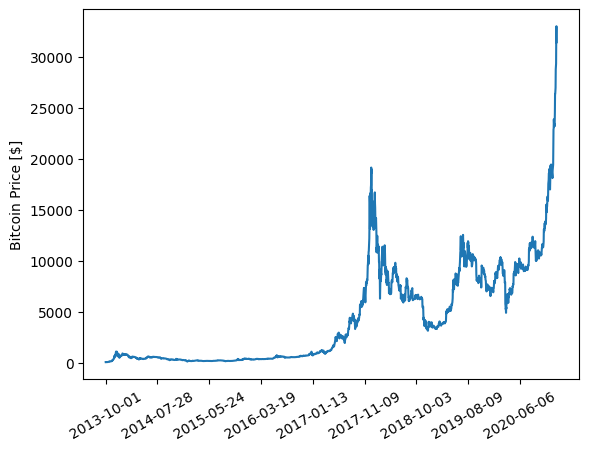

In [ ]:
def load_csv_from_url(url):
    import urllib.request, csv, io
    from collections import defaultdict

    with urllib.request.urlopen(url) as response:
        csv_data = response.read().decode('utf-8')
        csv_file = io.StringIO(csv_data)
        csv_reader = csv.DictReader(csv_file)

        # Store all data into a dictionary
        data_dict = defaultdict(list)
        for row in csv_reader:
            for key, value in row.items():
                data_dict[key].append(value)

        return data_dict

bitcoin_url = 'https://raw.githubusercontent.com/RDeconomist/observatory/main/Bitcoin%20Price.csv'
bitcoin_data = load_csv_from_url(bitcoin_url)
date = bitcoin_data['Date']
price = [float(v) for v in bitcoin_data['Closing Price (USD)']]


## Part (a) What are the minimum and maximum prices within this time period? In which days did they occur?
print(f'Date range: {date[0]} to {date[-1]}')
print(f'Min 1BTC=', min(price))
print(f'Min price occurred on', date[price.index(min(price))])
print(f'Max price occurred on', date[price.index(max(price))])

plt.plot(price)
plt.ylabel('Bitcoin Price [$]')
plt.gca().set_xticks(range(0, len(date), 300))
plt.gca().set_xticklabels(date[::300], rotation=30)
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, time_series, sequence_length):
        self.time_series = time_series
        self.sequence_length = sequence_length

    def __len__(self):
        # The total number of sequences in the time_series
        return len(self.time_series) - self.sequence_length

    def __getitem__(self, idx):
        # Extract the time sequence
        sequence = self.time_series[idx : idx + self.sequence_length]
        # Convert the sequence to a PyTorch tensor
        sequence = torch.tensor(sequence)
        return sequence

# Part (b)
print('=== Dataset ===')
sequence_length = 30
dataset = TimeSeriesDataset(price, sequence_length)

start_index = date.index('2017-12-01')
price_sequence = dataset[start_index]

print(f"Prices starting on 2017-12-01:\n ", price_sequence)

=== Dataset ===
Prices starting on 2017-12-01:
  tensor([ 9706.1035, 10923.2012, 10973.5439, 11382.2090, 11597.2314, 12230.3652,
        13734.5195, 16403.4219, 15732.0996, 13152.5283, 16299.2979, 16374.8975,
        16678.2871, 16246.1387, 17221.6504, 17436.5977, 19166.9785, 18640.2617,
        18984.7676, 16862.5703, 16925.0176, 14182.4648, 14694.5820, 14103.2188,
        13387.3486, 14652.3672, 15846.0742, 14362.4033, 14867.5723, 13643.6953])


### Linear Regression
Fitting a linear regression model to predict the bitcoin price on the 10th day from the previous 9 days.

In [ ]:
def loss(pred, y):
    """Mean Absolute Error loss"""
    return (pred - y).abs().mean()

# Part (d)
def train(model, loss, dataloader, optimizer):
    """Helper function to train our model."""
    total_error = 0.
    for it, sequences in enumerate(dataloader):

        # Prepare model inputs and targets
        price_history = sequences[:, :-1]
        actual_price_change = sequences[:, -1] - sequences[:, -2]

        # Compute model predictions
        predicted_price_change = model(price_history).squeeze()


        # Compute the loss
        l = loss(predicted_price_change, actual_price_change)
        total_error += l.item()

        # Update the weights
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    return total_error / len(dataloader)

def fit(model, loss, dataloader, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for ep in range(epochs):
        err = train(model, loss, dataloader, optimizer)
        print(f"[Ep{ep}] Error {err:.3f}")


price_history_len = 9
lr = 0.0005
batch_size = 32
epochs = 300

# Part (c)
model = nn.Linear(price_history_len, 1)
dataset = TimeSeriesDataset(price, 10)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
fit(model, loss, dataloader, epochs=epochs)

[Ep0] Error 6601.754
[Ep1] Error 5043.738
[Ep2] Error 3517.838
[Ep3] Error 1987.848
[Ep4] Error 533.648
[Ep5] Error 149.819
[Ep6] Error 148.561
[Ep7] Error 149.492
[Ep8] Error 149.281
[Ep9] Error 148.846
[Ep10] Error 149.035
[Ep11] Error 147.859
[Ep12] Error 146.899
[Ep13] Error 147.030
[Ep14] Error 147.528
[Ep15] Error 147.456
[Ep16] Error 147.319
[Ep17] Error 146.490
[Ep18] Error 146.471
[Ep19] Error 146.156
[Ep20] Error 146.663
[Ep21] Error 145.743
[Ep22] Error 146.323
[Ep23] Error 145.094
[Ep24] Error 144.406
[Ep25] Error 146.216
[Ep26] Error 144.071
[Ep27] Error 145.601
[Ep28] Error 143.663
[Ep29] Error 143.245
[Ep30] Error 143.873
[Ep31] Error 141.326
[Ep32] Error 143.538
[Ep33] Error 141.740
[Ep34] Error 141.212
[Ep35] Error 141.465
[Ep36] Error 141.697
[Ep37] Error 140.693
[Ep38] Error 141.191
[Ep39] Error 141.746
[Ep40] Error 141.184
[Ep41] Error 139.778
[Ep42] Error 140.519
[Ep43] Error 140.114
[Ep44] Error 138.691
[Ep45] Error 139.865
[Ep46] Error 140.134
[Ep47] Error 138.99

<ipython-input-24-3a4e82923dac>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(date, rotation=30)


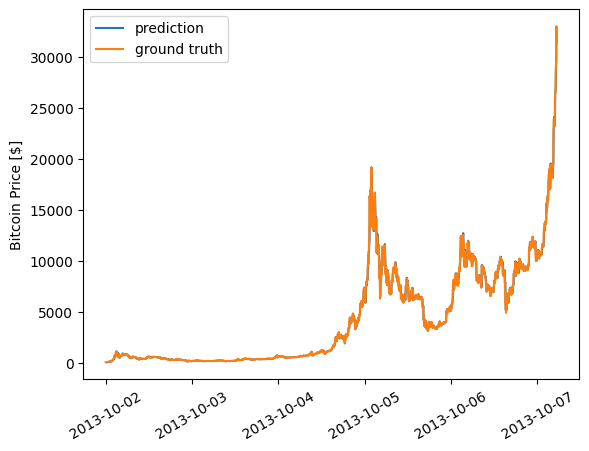

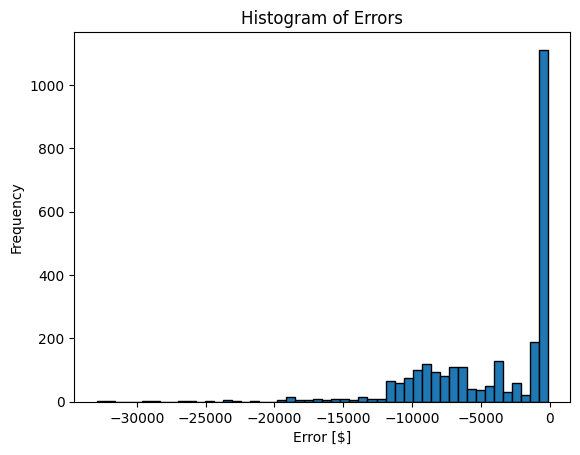

In [ ]:
with torch.no_grad():
    predictions, errors = [], []
    for i in range(len(dataset)):
        sequence = dataset[i]
        past = sequence[:-1]
        price_gt = sequence[-1]
        price_change_pred = model(past.unsqueeze(0)).item()

        err = price_change_pred - price_gt
        price_pred = past[-1] + price_change_pred

        errors.append(err.item())
        predictions.append(price_pred.item())

plt.plot([None]*9+predictions, label='prediction')
plt.plot(price, label='ground truth')
plt.ylabel('Bitcoin Price [$]')
plt.gca().set_xticklabels(date, rotation=30)
plt.legend()
plt.show()

plt.hist(errors, bins=50, edgecolor='black')
plt.xlabel('Error [$]')
plt.ylabel('Frequency')
plt.title('Histogram of Errors')
plt.show()